### BioCartis - Data/Exercise for interview.

In [1]:
# %load ../standard_import.txt
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% }</style>"))
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pydot
from IPython.display import Image

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score, confusion_matrix, accuracy_score, classification_report, log_loss
from math import sqrt

import graphviz
from IPython.display import Image

plt.style.use('seaborn-white')

In [3]:
## Getting the working path
cwd = os.getcwd()
print(cwd)

C:\Users\kamil\PycharmProjects\biocartis\notebooks


In [4]:
## Importing the training dataset to perform some explortatory analysis.
training = pd.read_csv("Trainingset.csv")
print(training.shape)
training.head(10)

(1000, 9)


,Unnamed: 0,cq,baseline,plateau,slope,inflection,asymmetry,drift,CurveCall
0,53369,39.381426,18.862292,35.527769,-0.447984,35.357707,5.5,0.036513,True
1,182009,26.649803,23.902034,25.035602,-0.138960,13.677998,5.5,0.026517,False
2,95707,38.088840,19.150485,37.676668,-0.429194,33.888961,5.5,0.043123,True
3,449346,38.118073,17.925782,37.875329,-0.412705,33.750390,5.5,-0.017076,True
4,292414,38.412099,16.631370,30.774217,-0.442670,34.340077,5.5,-0.002722,True
5,38215,49.776801,22.076942,23.693891,-0.918304,47.813874,5.5,0.077292,False
6,25925,38.333064,16.146603,33.834127,-0.445739,34.289073,5.5,0.031736,True
7,340630,40.031302,15.837696,44.779172,-0.400196,35.527106,5.5,0.057334,True
8,364434,NaN,15.685709,35.054909,-0.499235,46.789286,5.5,0.085738,False
9,107275,49.086742,20.537319,37.154088,-1.402519,51.872367,0.5,0.043466,False


In [5]:
# An initial fast overview of the data indicates the following:
# 1: The ID column "Unnamed: 0" can be used as index, also it need to be sorted numerically.
# 2. The dataset contains missing values or NAs, that need to be deal with to increase the accuracy.
training.rename(columns={"Unnamed: 0": "id"}, inplace=True)
training.set_index('id', inplace=True)
training.sort_index(axis=0, inplace=True)

In [6]:
training.head(10)

,cq,baseline,plateau,slope,inflection,asymmetry,drift,CurveCall
id,,,,,,,,
11860,15.724467,17.425718,18.561641,-0.161059,4.532523,5.500000,0.025464,False
14709,38.661613,16.055593,35.247591,-0.416284,34.331482,5.500000,0.043825,True
14710,39.099561,19.862337,41.030647,-0.412824,34.733139,5.500000,0.055549,True
14735,NaN,17.620658,38.399913,-0.400809,48.399249,5.500000,0.019397,False
14736,48.494417,21.716524,38.296494,-0.629313,48.006664,2.340075,0.049645,False
14738,18.851078,18.856889,21.200125,-0.183792,9.043452,5.500000,0.071017,False
15079,47.439514,21.967005,39.515621,-0.897198,48.767030,1.166117,0.016133,False
15081,NaN,17.805129,33.612546,-0.909044,60.000000,0.500000,0.009270,False
15091,47.293011,16.084766,35.305180,-0.416431,42.964410,5.500000,0.083140,False


In [7]:
# Finally a type check of the Dataframe columns
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 11860 to 455395
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   cq          819 non-null    float64
 1   baseline    1000 non-null   float64
 2   plateau     1000 non-null   float64
 3   slope       1000 non-null   float64
 4   inflection  1000 non-null   float64
 5   asymmetry   1000 non-null   float64
 6   drift       1000 non-null   float64
 7   CurveCall   1000 non-null   bool   
dtypes: bool(1), float64(7)
memory usage: 63.5 KB


### Initial Remarks

#### 1. Exploratory Analysis and Data Cleaning

In [8]:
training.describe()

,cq,baseline,plateau,slope,inflection,asymmetry,drift
count,819.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,37.143438,18.393905,38.119705,-0.456405,34.684044,4.364607,0.037798
std,9.895221,5.055759,46.755192,0.360630,13.699149,1.875227,0.050050
min,0.509646,-74.319376,11.268420,-4.564430,0.000000,0.500000,-0.355829
25%,37.841447,16.261901,23.445959,-0.471023,33.747544,3.224358,0.019646
50%,38.721260,18.518176,33.919381,-0.427451,34.728658,5.500000,0.035941
75%,40.812796,21.003851,40.241479,-0.317529,44.688536,5.500000,0.060591
max,49.982774,29.108979,741.077662,-0.010000,60.000000,5.500000,0.244130


In [9]:
'''
The presence of negative baseline values caught my attention. These values are an indicator of erroneous qPCR runs. However, the 
values are paired with NA Cq cells that will be treated on a posterior step.
'''
training.loc[training['baseline'] < 0] 

,cq,baseline,plateau,slope,inflection,asymmetry,drift,CurveCall
id,,,,,,,,
109483,NaN,-43.882490,73.231064,-0.023033,57.832772,0.500000,-0.313528,False
151648,NaN,-17.445642,220.357859,-0.010000,48.116923,2.143508,-0.315159,False
259637,NaN,-74.319376,89.834815,-0.018929,54.561807,0.500000,-0.340477,False


In [10]:
training.sort_values('plateau', axis=0, ascending=False).head(20) 

## Also caught my attention the elevated values observed in the plateau. Interestingly, all of the high values correspond to 
## NAs in the Cq and False outcome. 

,cq,baseline,plateau,slope,inflection,asymmetry,drift,CurveCall
id,,,,,,,,
365105,NaN,18.521630,741.077662,-1.570578,60.000000,0.500000,0.046456,False
238377,NaN,20.744253,651.131295,-1.462305,60.000000,0.500000,0.002884,False
25427,NaN,21.691506,630.906091,-1.886270,58.301088,0.500000,0.036881,False
288773,NaN,19.413430,429.743045,-1.685752,60.000000,0.500000,0.047845,False
17388,NaN,25.278132,339.405874,-1.851215,58.781826,0.500000,0.118910,False
374808,NaN,12.034642,324.472219,-1.429446,60.000000,0.500000,0.023696,False
288760,NaN,16.004727,319.341324,-1.429923,60.000000,0.500000,0.016645,False
267025,NaN,25.684865,311.851577,-1.705247,59.607294,0.500000,0.069433,False
25842,NaN,22.456199,272.463058,-1.353344,60.000000,0.500000,0.085578,False


cq            181
baseline        0
plateau         0
slope           0
inflection      0
asymmetry       0
drift           0
CurveCall       0
dtype: int64


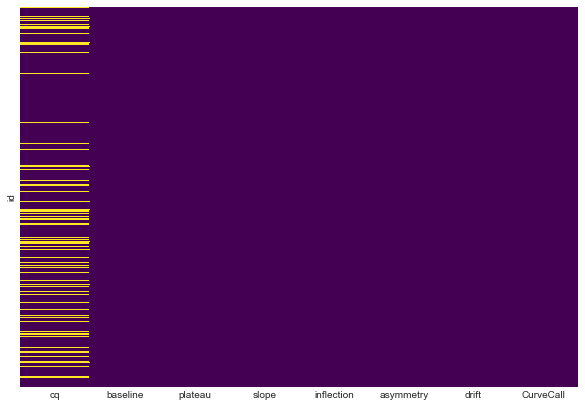

In [61]:
plt.figure(figsize=(10, 7))
sns.heatmap(training.isnull(), yticklabels=False, cbar=False, cmap='viridis')

print(training.isnull().sum())

In [12]:
# Visualizing the raw data can give an indicate of the type of data missing as well the variable to predict
training[training['cq'].isnull()].head(10)

,cq,baseline,plateau,slope,inflection,asymmetry,drift,CurveCall
id,,,,,,,,
14735,NaN,17.620658,38.399913,-0.400809,48.399249,5.500000,0.019397,False
15081,NaN,17.805129,33.612546,-0.909044,60.000000,0.500000,0.009270,False
15094,NaN,20.971992,22.768357,-0.760841,47.545477,5.500000,0.021830,False
15113,NaN,23.273532,25.959789,-0.037998,18.582638,0.500000,0.032511,False
15166,NaN,15.970436,22.508026,-0.090968,0.000000,0.500000,0.028725,False
17381,NaN,16.355053,17.901285,-0.010000,38.174276,1.530273,0.077892,False
17388,NaN,25.278132,339.405874,-1.851215,58.781826,0.500000,0.118910,False
17402,NaN,22.123499,30.786033,-0.627509,48.369668,5.500000,0.038653,False
17409,NaN,20.379266,20.954648,-0.010000,39.226274,1.010567,0.029987,False


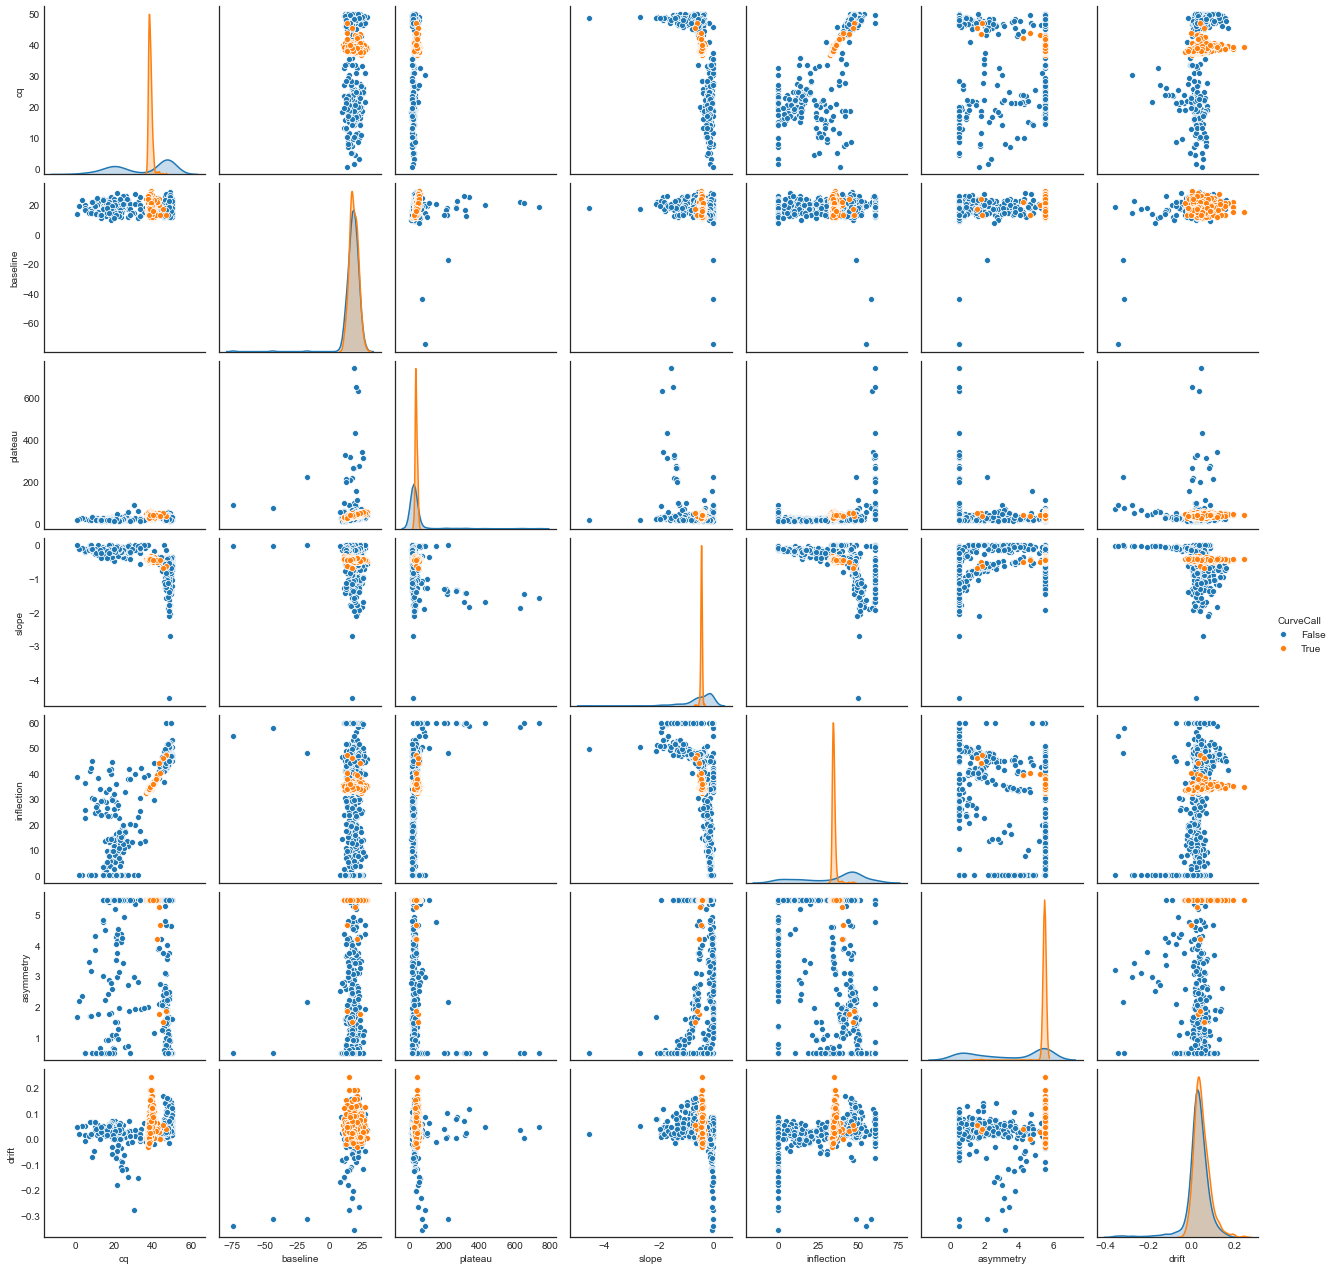

In [13]:
sns.pairplot(training, hue='CurveCall')

#### 1.1 Siginificant outlier

<AxesSubplot:ylabel='id'>

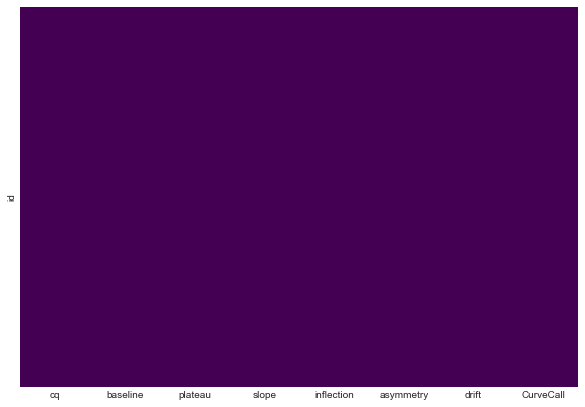

In [15]:
## Filling the NAs with -99999 to train the classifier into a significant outlier
train_significant_outlier = training.fillna(value=-99999)
plt.figure(figsize=(10, 7))

sns.heatmap(train_significant_outlier.isnull(), yticklabels=False, cbar=False, cmap='viridis')

#### 1.2 Cq+1

In [16]:
## 
print(training["cq"].max())
train_cqmax = training.fillna(value=training["cq"].max()+1)
train_cqmax[train_cqmax['cq'] > 50].head(10)

49.982774360753005


,cq,baseline,plateau,slope,inflection,asymmetry,drift,CurveCall
id,,,,,,,,
14735,50.982774,17.620658,38.399913,-0.400809,48.399249,5.500000,0.019397,False
15081,50.982774,17.805129,33.612546,-0.909044,60.000000,0.500000,0.009270,False
15094,50.982774,20.971992,22.768357,-0.760841,47.545477,5.500000,0.021830,False
15113,50.982774,23.273532,25.959789,-0.037998,18.582638,0.500000,0.032511,False
15166,50.982774,15.970436,22.508026,-0.090968,0.000000,0.500000,0.028725,False
17381,50.982774,16.355053,17.901285,-0.010000,38.174276,1.530273,0.077892,False
17388,50.982774,25.278132,339.405874,-1.851215,58.781826,0.500000,0.118910,False
17402,50.982774,22.123499,30.786033,-0.627509,48.369668,5.500000,0.038653,False
17409,50.982774,20.379266,20.954648,-0.010000,39.226274,1.010567,0.029987,False


<AxesSubplot:xlabel='CurveCall', ylabel='count'>

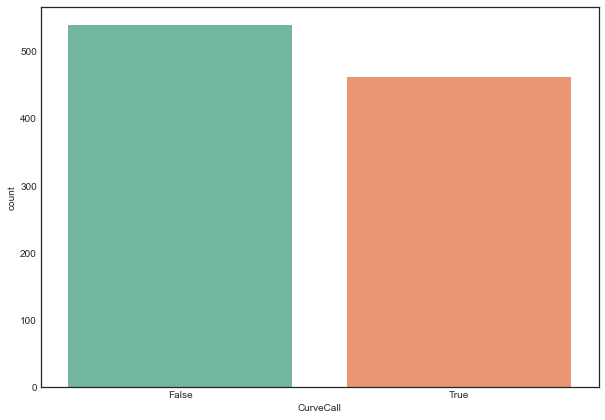

In [17]:
# Checking the distribution between outcomes in the variable to be predicted (curve call).
# An overall similar ration between True/False are observed.
plt.figure(figsize=(10, 7))
sns.countplot(x = 'CurveCall', data = training, palette = 'Set2')

### 2. Feature Importance

In [66]:
def feature_importance_checker(dataframe_test):
    # Spliting the dataset into the labels and predictor
    X = dataframe_test.drop('CurveCall', axis=1)
    y = dataframe_test['CurveCall']
    
    print(X.shape)
    print(y.shape)
    
    ## Run a Tree-Based estimators 
    dt = DecisionTreeClassifier(random_state=20, criterion ='entropy', max_depth = 10)
    dt.fit(X,y)
    
    plt.figure(figsize=(10, 7))

    #tree.plot_tree(dt) 
    # Starting with two empty list who will be populated.
    fi_col = []
    fi = []
    
    for i, column in enumerate(dataframe_test.drop('CurveCall', axis=1)):
        print ('The feature importance for {} is: {}'.format(column, dt.feature_importances_[i]))
    
        fi_col.append(column)
        fi.append(dt.feature_importances_[i])
    
    fi_df = zip(fi_col, fi)
    fi_df = pd.DataFrame(fi_df, columns = ['Feature','Feature Importance'])
    
    # print(dt.classes_)
    
    dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=X.columns,  
                     class_names=str(dt.classes_),  
                     filled=True, rounded=True,  
                     special_characters=True                                   )  
    graphviz.Source(dot_data)  
    
    plt.show()
    
    # Ordering the data 
    fi_df = fi_df.sort_values('Feature Importance', ascending = False).reset_index()
    return fi_df 

#### Cq Significant outlier

In [67]:
feature_importance_checker(train_significant_outlier)

(1000, 7)
(1000,)
The feature importance for cq is: 0.43914162908039783
The feature importance for baseline is: 0.006282144192829925
The feature importance for plateau is: 0.015252435832541385
The feature importance for slope is: 0.02097916466155299
The feature importance for inflection is: 0.5163358011844127
The feature importance for asymmetry is: 0.0
The feature importance for drift is: 0.00200882504826523


<Figure size 720x504 with 0 Axes>

,index,Feature,Feature Importance
0,4,inflection,0.516336
1,0,cq,0.439142
2,3,slope,0.020979
3,2,plateau,0.015252
4,1,baseline,0.006282
5,6,drift,0.002009
6,5,asymmetry,0.000000


#### Cq (Max) + 1

In [68]:
feature_importance_checker(train_cqmax)

(1000, 7)
(1000,)
The feature importance for cq is: 0.917052146878095
The feature importance for baseline is: 0.004159984842975034
The feature importance for plateau is: 0.01293128925220848
The feature importance for slope is: 0.002358878427117537
The feature importance for inflection is: 0.06349770059960401
The feature importance for asymmetry is: 0.0
The feature importance for drift is: 0.0


<Figure size 720x504 with 0 Axes>

,index,Feature,Feature Importance
0,0,cq,0.917052
1,4,inflection,0.063498
2,2,plateau,0.012931
3,1,baseline,0.004160
4,3,slope,0.002359
5,5,asymmetry,0.000000
6,6,drift,0.000000


### Using Hold-Out Validation

In [69]:
# Splitting the data into X and Y
# Spliting the dataset into the labels and predictor
X = train_significant_outlier.drop('CurveCall', axis=1)
y = train_significant_outlier['CurveCall']

# First Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state = 28)

# Second one
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.9, test_size=0.1, random_state= 28)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)


(720, 7)
(200, 7)
(80, 7)
(720,)
(200,)
(80,)


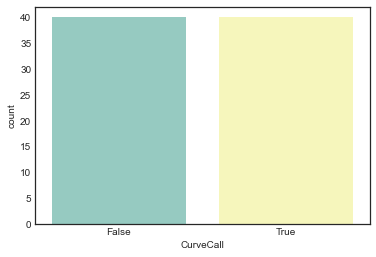

In [70]:
# Investigating the distr of all ys
ax = sns.countplot(x = y_valid, palette = "Set3")

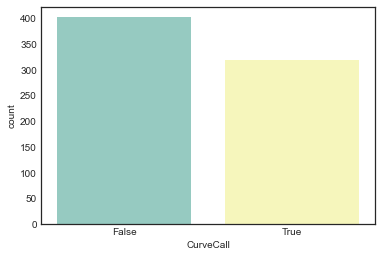

In [71]:
ax = sns.countplot(x = y_train, palette = "Set3")

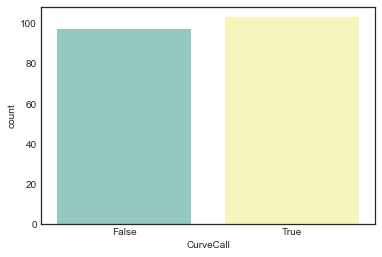

In [72]:
ax = sns.countplot(x = y_test, palette = "Set3")

### Running the Logistic Regression

In [127]:
logmodel = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=31)

logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=31)

In [74]:
# predict - Predict class labels for samples in X
logmodel.predict(X_train)
y_pred = logmodel.predict(X_train)

In [75]:
# predict_proba - Probability estimates
pred_proba = logmodel.predict_proba(X_train)

# coef_ - Coefficient of the features in the decision function
logmodel.coef_

array([[ 2.13096732e-03, -4.31565791e-01,  3.07637425e-01,
        -1.34780047e+00, -2.79600604e-02,  2.54550861e+00,
         2.96007888e-01]])

### Model Evaluation

In [76]:
# Accuracy on Train
print("The Training Accuracy is: ", logmodel.score(X_train, y_train))

# Accuracy on Test
print("The Testing Accuracy is: ", logmodel.score(X_test, y_test))

# Classification Report
print(classification_report(y_train, y_pred))

The Training Accuracy is:  0.9458333333333333
The Testing Accuracy is:  0.96
              precision    recall  f1-score   support

       False       0.99      0.91      0.95       402
        True       0.90      0.99      0.94       318

    accuracy                           0.95       720
   macro avg       0.94      0.95      0.95       720
weighted avg       0.95      0.95      0.95       720



In [80]:
## Creating a confuion Matrix

def plot_confusion_matrices(cm, classes=None, title='Confusion Matrix'):
    """Plots a confusion matrix."""
    if classes is not None:
        sns.heatmap(cm, cmap="YlGnBu", xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':50})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

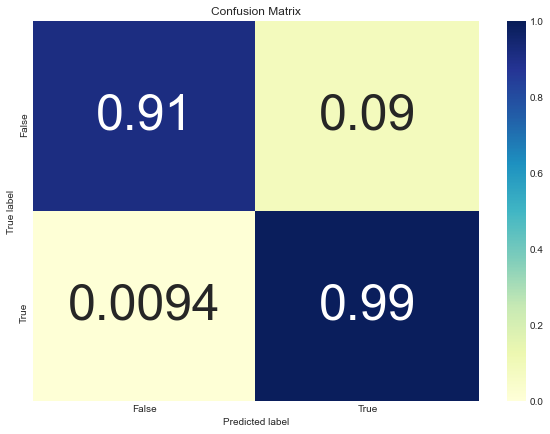

In [83]:
## Visualization
cm = confusion_matrix(y_train, y_pred)
cm_norm = cm / cm.sum(axis=1).reshape(-1, 1)

plt.figure(figsize=(10, 7))
plot_confusion_matrices(cm_norm, classes=logmodel.classes_)

#### Calculating the False/True Positives and False/True Negatives

In [86]:
print(logmodel.classes_)
print(cm.sum(axis=1))
cm_norm

[False  True]
[402 318]


array([[0.91044776, 0.08955224],
       [0.00943396, 0.99056604]])

In [89]:
print(cm.sum(axis=0))
cm

[369 351]


array([[366,  36],
       [  3, 315]], dtype=int64)

In [90]:
np.diag(cm)

array([366, 315], dtype=int64)

In [92]:
false_positives = cm.sum(axis=0) - np.diag(cm)
false_negatives = cm.sum(axis=1) - np.diag(cm)
true_positives = np.diag(cm)
true_negatives = cm.sum() - (false_negatives + false_positives + true_positives)

In [103]:
## Calculating the true positive ratio (sensitivity - hit rate - recall)
true_positive_rate = true_positives / (true_positives + false_negatives)
print("The True Positive Rate is:", true_positive_rate)
print(" ")

## Calculating the precision or positive predictive rate
positive_predictive_value = true_positives / (true_positives + false_negatives)
print("The Positive Predictive Value is:", positive_predictive_value)
print(" ")

## False Positive Rate or False alarm rate
false_positive_rate = false_positives / (false_positives + true_negatives)
print("The False Positive Rate is:", false_positive_rate)
print(" ")

## False Negative Rate or Miss Rate
false_negative_rate = false_negatives / (false_negatives +  true_positives)
print("The False Positive Rate is:", false_positive_rate)
print(" ")

## Total Averages:
print("The average True Positive Rate is:", true_positive_rate.sum()/2)
print("The average Precision is:", positive_predictive_value.sum()/2)
print("The Average False Positive Rate is:", false_positive_rate.sum()/2)
print("The Average False Negative Rate is:", false_negative_rate.sum()/2)

The True Positive Rate is: [0.91044776 0.99056604]
 
The Positive Predictive Value is: [0.91044776 0.99056604]
 
The False Positive Rate is: [0.00943396 0.08955224]
 
The False Positive Rate is: [0.00943396 0.08955224]
 
The average True Positive Rate is: 0.9505068994649395
The average Precision is: 0.9505068994649395
The Average False Positive Rate is: 0.04949310053506054
The Average False Negative Rate is: 0.04949310053506054


In [107]:
## Running the logarithmic loss on the training data
print("the Log loss on the Training data is:", log_loss(y_train, pred_proba))

## Running the logarithmic loss on the Test data
pred_proba_t = logmodel.predict_proba(X_test)
print("the Log loss on the Test data is:", log_loss(y_test, pred_proba_t))


the Log loss on the Training data is: 0.1918985573796432
the Log loss on the Test data is: 0.166979000410861


### HyperParameter tunning

In [109]:
np.geomspace(1e-5, 1e5, num=20)

array([1.00000000e-05, 3.35981829e-05, 1.12883789e-04, 3.79269019e-04,
       1.27427499e-03, 4.28133240e-03, 1.43844989e-02, 4.83293024e-02,
       1.62377674e-01, 5.45559478e-01, 1.83298071e+00, 6.15848211e+00,
       2.06913808e+01, 6.95192796e+01, 2.33572147e+02, 7.84759970e+02,
       2.63665090e+03, 8.85866790e+03, 2.97635144e+04, 1.00000000e+05])

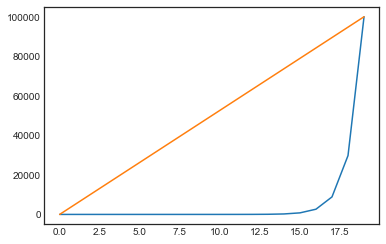

In [112]:
# Creating a range for C values
np.geomspace(1e-5, 1e5, num=20)

# ploting it
plt.plot(np.geomspace(1e-5, 1e5, num=20)) #  uniformly distributed in log space
plt.plot(np.linspace(1e-5, 1e5, num=20)) # uniformly distributed in linear space, instead of log space

In [119]:
## Applying the tunning of C in the regression model. 

c_list = np.geomspace(1e-5, 1e5, num = 20)
ca = []
logarithmic_loss = []

# looping over the fit parameters.
for c in c_list:
    logmodel2 = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=31, C=c)
    logmodel2.fit(X_train, y_train)
    score = logmodel2.score(X_test, y_test)
    ca.append(score)
    print('The CA of C parameter {}: is {}'.format(c, score))

    pred_proba_t = logmodel2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_t)
    logarithmic_loss.append(log_loss2)
    print("The Log Loss of C parameter {} is: {}".format(c, log_loss2))
    print(" ")

The CA of C parameter 1e-05: is 0.86
The Log Loss of C parameter 1e-05 is: 0.5105186125081536
 
The CA of C parameter 3.359818286283781e-05: is 0.885
The Log Loss of C parameter 3.359818286283781e-05 is: 0.45219312539284107
 
The CA of C parameter 0.00011288378916846884: is 0.725
The Log Loss of C parameter 0.00011288378916846884 is: 0.49728853592337247
 
The CA of C parameter 0.000379269019073225: is 0.92
The Log Loss of C parameter 0.000379269019073225 is: 0.31057973791881677
 
The CA of C parameter 0.0012742749857031334: is 0.94
The Log Loss of C parameter 0.0012742749857031334 is: 0.2530294161781294
 

C:\Users\kamil\anaconda3\envs\biocartis\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



The CA of C parameter 0.004281332398719391: is 0.955
The Log Loss of C parameter 0.004281332398719391 is: 0.21003057549253043
 
The CA of C parameter 0.01438449888287663: is 0.955
The Log Loss of C parameter 0.01438449888287663 is: 0.18350155001303947
 
The CA of C parameter 0.04832930238571752: is 0.955
The Log Loss of C parameter 0.04832930238571752 is: 0.1693348413210689
 
The CA of C parameter 0.1623776739188721: is 0.955
The Log Loss of C parameter 0.1623776739188721 is: 0.16456839346568905
 
The CA of C parameter 0.5455594781168515: is 0.955
The Log Loss of C parameter 0.5455594781168515 is: 0.16559343905921792
 
The CA of C parameter 1.8329807108324339: is 0.96
The Log Loss of C parameter 1.8329807108324339 is: 0.16722353936200604
 
The CA of C parameter 6.1584821106602545: is 0.96
The Log Loss of C parameter 6.1584821106602545 is: 0.1682576204102395
 
The CA of C parameter 20.6913808111479: is 0.965
The Log Loss of C parameter 20.6913808111479 is: 0.1696405509099012
 
The CA o

In [129]:
# Creating a dataframe with the C / CA values found.

# Reshaping the data
ca_square = np.array(ca).reshape(20,)
logarithmic_loss_2 = np.array(logarithmic_loss).reshape(20,)

# Zipping the values and creating a dataframe
c_outcomes = zip(c_list, ca_square, logarithmic_loss_2)
df_c_outcomes = pd.DataFrame(c_outcomes, columns=['C_list', 'CA2', 'logarithmic_loss_2'])

df_c_outcomes.sort_values('logarithmic_loss_2', ascending=True).reset_index()

,index,C_list,CA2,logarithmic_loss_2
0,8,0.162378,0.955,0.164568
1,9,0.545559,0.955,0.165593
2,10,1.832981,0.960,0.167224
3,11,6.158482,0.960,0.168258
4,7,0.048329,0.955,0.169335
5,14,233.572147,0.965,0.169545
6,12,20.691381,0.965,0.169641
7,13,69.519280,0.965,0.170368
8,15,784.759970,0.965,0.170785
9,19,100000.000000,0.965,0.170806


In [121]:
## using Cross Validation as second way to tune the C parameter
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold

In [130]:
kf3 = KFold(n_splits = 3, random_state= 0, shuffle=True)
# Performing the Logistic Regression Cross Validated
logmodel3 = LogisticRegressionCV(solver='lbfgs', max_iter=1000, random_state=31, Cs=c_list)
logmodel3.fit(X_train, y_train)
print("The CA is:", logmodel3.score(X_test, y_test))
print("")

# Calculating the predicted Probability
pred_proba_t = logmodel3.predict_log_proba(X_test)
log_loss3 = log_loss(y_test, pred_proba_t)
print("The Logaritmic Loss is:", log_loss3)
print("")

# Obtaining the optima C Parameter
print("The optimal C parameter is:", logmodel3.C_)

The CA is: 0.965

The Logaritmic Loss is: 0.6931471805599452

The optimal C parameter is: [8858.6679041]


The CA of C parameter 1e-05 is 0.86:
The Logg Loss of C parameter 1e-05 is 0.5105186125081536:



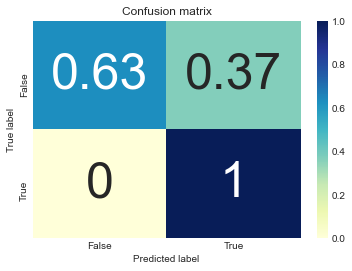

The CA of C parameter 3.359818286283781e-05 is 0.885:
The Logg Loss of C parameter 3.359818286283781e-05 is 0.45219312539284107:



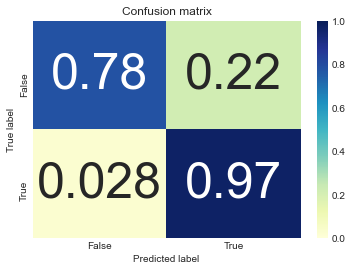

C:\Users\kamil\anaconda3\envs\biocartis\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


The CA of C parameter 0.00011288378916846884 is 0.725:
The Logg Loss of C parameter 0.00011288378916846884 is 0.49728853592337247:



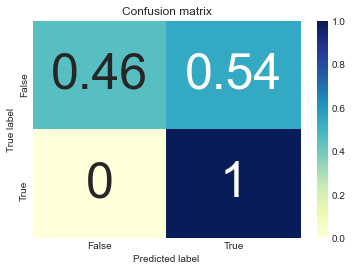

The CA of C parameter 0.000379269019073225 is 0.92:
The Logg Loss of C parameter 0.000379269019073225 is 0.31057973791881677:



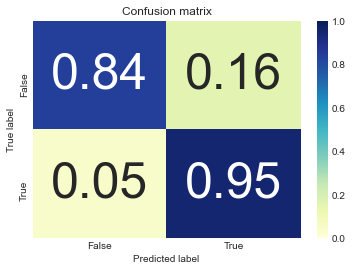

The CA of C parameter 0.0012742749857031334 is 0.94:
The Logg Loss of C parameter 0.0012742749857031334 is 0.2530294161781294:



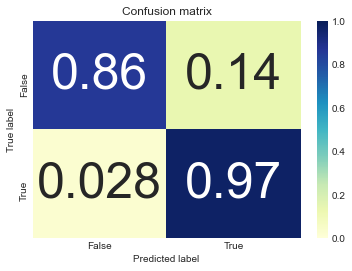

The CA of C parameter 0.004281332398719391 is 0.955:
The Logg Loss of C parameter 0.004281332398719391 is 0.21003057549253043:



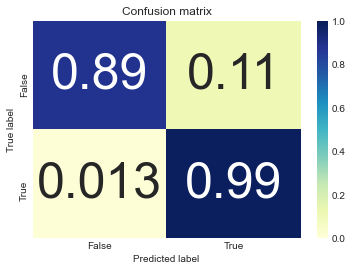

The CA of C parameter 0.01438449888287663 is 0.955:
The Logg Loss of C parameter 0.01438449888287663 is 0.18350155001303947:



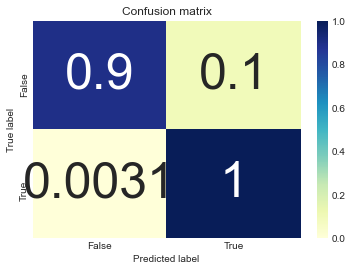

The CA of C parameter 0.04832930238571752 is 0.955:
The Logg Loss of C parameter 0.04832930238571752 is 0.1693348413210689:



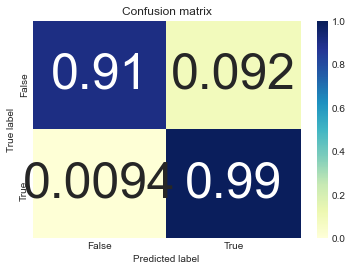

The CA of C parameter 0.1623776739188721 is 0.955:
The Logg Loss of C parameter 0.1623776739188721 is 0.16456839346568905:



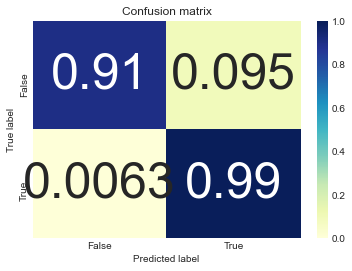

The CA of C parameter 0.5455594781168515 is 0.955:
The Logg Loss of C parameter 0.5455594781168515 is 0.16559343905921792:



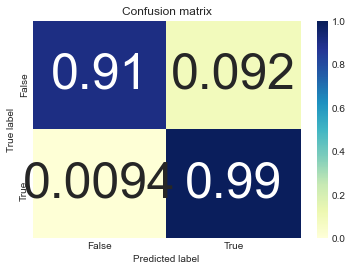

The CA of C parameter 1.8329807108324339 is 0.96:
The Logg Loss of C parameter 1.8329807108324339 is 0.16722353936200604:



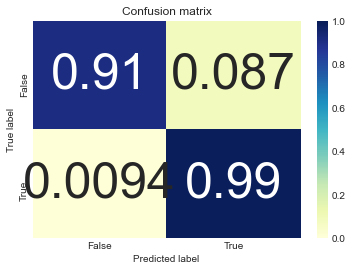

The CA of C parameter 6.1584821106602545 is 0.96:
The Logg Loss of C parameter 6.1584821106602545 is 0.1682576204102395:



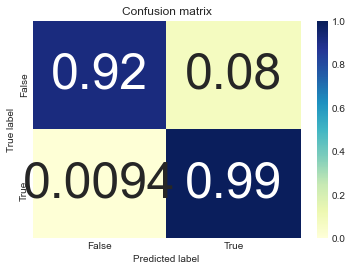

The CA of C parameter 20.6913808111479 is 0.965:
The Logg Loss of C parameter 20.6913808111479 is 0.1696405509099012:



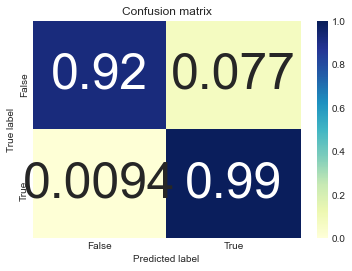

The CA of C parameter 69.51927961775606 is 0.965:
The Logg Loss of C parameter 69.51927961775606 is 0.17036832643495614:



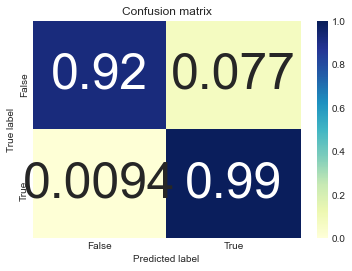

The CA of C parameter 233.57214690901213 is 0.965:
The Logg Loss of C parameter 233.57214690901213 is 0.1695446277947925:



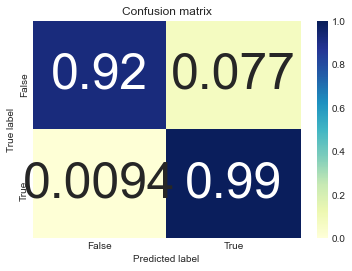

The CA of C parameter 784.7599703514607 is 0.965:
The Logg Loss of C parameter 784.7599703514607 is 0.1707849901616148:



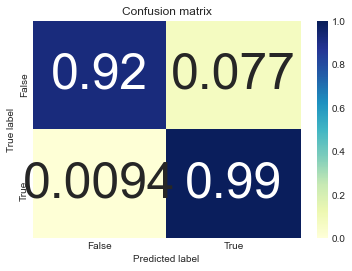

The CA of C parameter 2636.6508987303555 is 0.965:
The Logg Loss of C parameter 2636.6508987303555 is 0.17081508252640565:



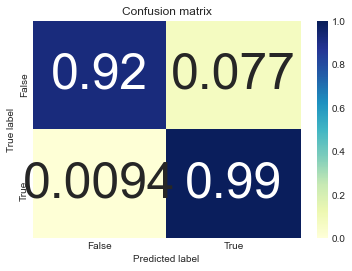

The CA of C parameter 8858.667904100832 is 0.965:
The Logg Loss of C parameter 8858.667904100832 is 0.17082187888475267:



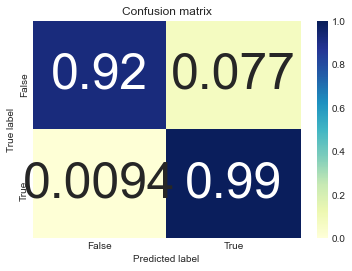

The CA of C parameter 29763.51441631313 is 0.965:
The Logg Loss of C parameter 29763.51441631313 is 0.17085587065711905:



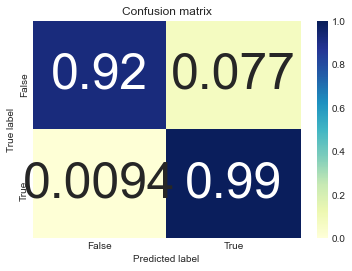

The CA of C parameter 100000.0 is 0.965:
The Logg Loss of C parameter 100000.0 is 0.17080634664036964:



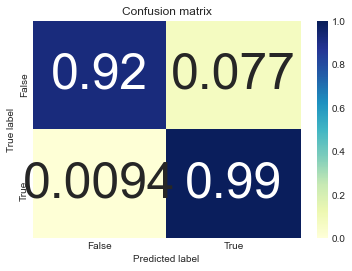

In [135]:
c_list = np.geomspace(1e-5, 1e5, num=20)
ca = []
logarithmic_loss = []

for c in c_list:
    logmodel2 = LogisticRegression(random_state=31, solver = 'lbfgs', C=c, max_iter=1000)
    logmodel2.fit(X_train, y_train)
    score = logmodel2.score(X_test, y_test)
    ca.append(score)
    
    print("The CA of C parameter {} is {}:".format(c, score))
    
    pred_proba_t = logmodel2.predict_proba(X_test)
    log_loss2 = log_loss(y_test, pred_proba_t)
    logarithmic_loss.append(log_loss2)
    print("The Logg Loss of C parameter {} is {}:".format(c, log_loss2))
    print("")
    
    y_pred = logmodel2.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    cm_norm = cm / cm.sum(axis=1).reshape(-1,1)
    
    plot_confusion_matrices(cm_norm, classes = logmodel.classes_, title='Confusion matrix')
    plt.show()

#### Testing on an dummy Classifier

In [136]:
## Good practices: Create a dummy classifier, and training it before the model 
## have contact with real data.
from sklearn.dummy import DummyClassifier

In [139]:
dummy_classifier = DummyClassifier(strategy='most_frequent')
dummy_classifier.fit(X_train, y_train)
score = dummy_classifier.score(X_test, y_test)

pred_proba_t = dummy_classifier.predict_proba(X_test)
log_loss2 = log_loss(y_test, pred_proba_t)

print("Testing Accuracy:", score)
print("Log Loss:", log_loss2)

Testing Accuracy: 0.485
Log Loss: 17.787469843379


### Final Model with selected C values

In [140]:
# Final Model
logmodel_final = LogisticRegression(random_state=31, solver= 'lbfgs', C=0.162378, max_iter=1000)
logmodel_final.fit(X_train, y_train)
score = logmodel_final.score(X_valid, y_valid)

## The predicted probabilities
pred_proba_t = logmodel_final.predict_proba(X_valid)
log_loss_final = log_loss(y_valid, pred_proba_t)

print("The Testing accuracy in validation data is:", score)
print("The log loss in the validation Data is:", log_loss_final)

The Testing accuracy in validation data is: 0.9625
The log loss in the vlaidation Data is: 0.12532588611207107


In [141]:
# Final Model 2 - using the cross validated regression.
logmodel_final = LogisticRegression(random_state=31, solver= 'lbfgs', C=8858.667904, max_iter=1000)
logmodel_final.fit(X_train, y_train)
score = logmodel_final.score(X_valid, y_valid)

## The predicted probabilities
pred_proba_t = logmodel_final.predict_proba(X_valid)
log_loss_final = log_loss(y_valid, pred_proba_t)

print("The Testing accuracy in validation data is:", score)
print("The log loss in the validation Data is:", log_loss_final)

The Testing accuracy in validation data is: 0.9875
The log loss in the validation Data is: 0.08688448644978877


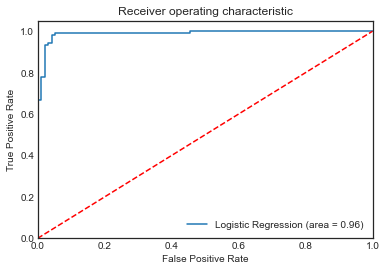

In [143]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel_final.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel_final.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

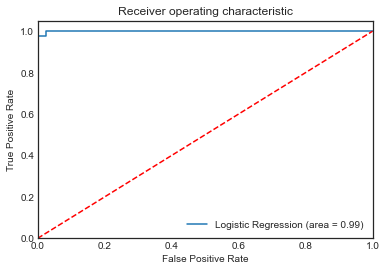

In [144]:
logit_roc_auc = roc_auc_score(y_valid, logmodel_final.predict(X_valid))
fpr, tpr, thresholds = roc_curve(y_valid, logmodel_final.predict_proba(X_valid)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [147]:
# Finalize model
import pickle
logmodel_final = LogisticRegression(random_state=31, solver= 'lbfgs', C=8858.667904, max_iter=1000)
logmodel_final.fit(X_train, y_train)

# Save model to disk
filename = 'Final_Model.sav'
pickle.dump(logmodel_final, open(filename, 'wb'))



In [148]:
# Load model from disk and use it to make new predictions
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_valid, y_valid)
print(result)

# Load test dataset


0.9875


In [156]:
final_predict = pd.read_csv("Validationset.csv")
final_predict.rename(columns={"Unnamed: 0": "id"}, inplace=True)
final_predict.set_index('id', inplace=True)
final_predict.sort_index(axis=0, inplace=True)
final_predict

,cq,baseline,plateau,slope,inflection,asymmetry,drift
id,,,,,,,
14726,38.670836,11.885578,26.926569,-0.404163,34.210850,5.500000,0.047420
15107,22.874179,21.445045,22.434226,-0.157883,14.922006,3.962626,0.034419
15122,24.355958,22.148880,24.057369,-0.176038,14.116340,5.500000,0.027256
15137,44.767309,19.613494,41.719725,-0.479926,41.011392,5.500000,0.038288
19946,38.412793,18.993733,42.965284,-0.412675,34.044800,5.500000,0.065527
...,...,...,...,...,...,...,...
434796,NaN,-78.751009,76.641007,-0.022739,48.327875,0.500000,-0.427222
434803,NaN,11.579685,13.363196,-0.074373,0.000000,1.094165,0.021720
441197,45.545784,12.174307,22.971063,-1.014011,48.080364,0.715661,0.010067


In [157]:
final_predict = final_predict.fillna(value=-99999)
final_predict

,cq,baseline,plateau,slope,inflection,asymmetry,drift
id,,,,,,,
14726,38.670836,11.885578,26.926569,-0.404163,34.210850,5.500000,0.047420
15107,22.874179,21.445045,22.434226,-0.157883,14.922006,3.962626,0.034419
15122,24.355958,22.148880,24.057369,-0.176038,14.116340,5.500000,0.027256
15137,44.767309,19.613494,41.719725,-0.479926,41.011392,5.500000,0.038288
19946,38.412793,18.993733,42.965284,-0.412675,34.044800,5.500000,0.065527
...,...,...,...,...,...,...,...
434796,-99999.000000,-78.751009,76.641007,-0.022739,48.327875,0.500000,-0.427222
434803,-99999.000000,11.579685,13.363196,-0.074373,0.000000,1.094165,0.021720
441197,45.545784,12.174307,22.971063,-1.014011,48.080364,0.715661,0.010067


In [168]:
X_train = final_predict
pred = logmodel_final.predict(X_train)
print(pred)
print(len(pred))

[ True False False  True  True False False False False False  True False
  True False  True False  True  True  True  True False  True  True  True
  True  True  True  True  True False False  True  True  True False  True
  True False  True  True False  True  True False False  True False False
 False  True False False  True  True  True False  True False False False
  True  True False False  True False False False  True  True False False
  True  True False  True  True  True  True False  True  True  True False
  True  True  True False False False False False False False False False
 False False  True  True]
100


In [161]:
# Zipping the values and creating a dataframe
result = zip(X_train, pred)
result_final = pd.DataFrame(result, columns=['cq', 'baseline', 'plateau', 'slope', 'inflection', 'asymmetry', 'drift', 'predicted_CurveCall'])

ValueError: 8 columns passed, passed data had 2 columns

In [177]:
df1 = pd.DataFrame(data=pred)
df1

,0
0,True
1,False
2,False
3,True
4,True
...,...
95,False
96,False
97,False
98,True


In [174]:
test = final_predict.reset_index()
test

,id,cq,baseline,plateau,slope,inflection,asymmetry,drift
0,14726,38.670836,11.885578,26.926569,-0.404163,34.210850,5.500000,0.047420
1,15107,22.874179,21.445045,22.434226,-0.157883,14.922006,3.962626,0.034419
2,15122,24.355958,22.148880,24.057369,-0.176038,14.116340,5.500000,0.027256
3,15137,44.767309,19.613494,41.719725,-0.479926,41.011392,5.500000,0.038288
4,19946,38.412793,18.993733,42.965284,-0.412675,34.044800,5.500000,0.065527
...,...,...,...,...,...,...,...,...
95,434796,-99999.000000,-78.751009,76.641007,-0.022739,48.327875,0.500000,-0.427222
96,434803,-99999.000000,11.579685,13.363196,-0.074373,0.000000,1.094165,0.021720
97,441197,45.545784,12.174307,22.971063,-1.014011,48.080364,0.715661,0.010067
98,441277,38.879085,14.864933,38.677119,-0.421525,34.602799,5.500000,0.125165


In [181]:
fina_result = pd.concat([test, df1], axis=1)
fina_result.tail(50)

,id,cq,baseline,plateau,slope,inflection,asymmetry,drift,0
50,154268,22.318930,24.838107,25.765632,-0.293480,25.158334,1.355013,0.031959,False
51,154278,8.274999,15.810613,17.434449,-0.244631,24.245549,0.500000,0.027418,False
52,157998,38.081951,16.311319,36.373506,-0.441180,33.996172,5.500000,0.027692,True
53,162013,38.877373,17.050834,36.838122,-0.443097,34.809269,5.500000,0.028525,True
54,162019,38.164374,17.318780,35.651234,-0.433013,34.001537,5.500000,0.022754,True
55,163827,-99999.000000,15.883685,16.770708,-0.393714,20.005494,0.500000,0.005710,False
56,169786,39.954322,14.706183,32.942591,-0.392349,35.360042,5.500000,0.115028,True
57,177481,-99999.000000,24.138886,39.839426,-0.455031,48.087856,5.500000,0.054875,False
58,177652,-99999.000000,21.340565,57.421020,-0.398227,45.997030,5.500000,0.041519,False
59,177657,-99999.000000,24.150114,25.331368,-0.010000,39.649809,1.255913,0.064993,False
